# Exploratory Data Analysis

Chosen team: **Marketplace team**

Questions to answer:
1. Which pickup locations contribute most to the number of Speedr trips?
1. Which trip type is more common? Which trip type generates more revenue?
2. At what time do the number of commuters peak?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 12})

# Loading datasets

First, we would like to load the necessary datasets. Afterwards, we will merge all datasets into one dataframe and perform feature engineering if necessary.

## `dim_user`

In [2]:
dim_user = pd.read_csv('dim_user.csv')
dim_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10724 entries, 0 to 10723
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      10724 non-null  int64 
 1   signup_date  10724 non-null  object
 2   gender       10724 non-null  int64 
 3   birth_year   10724 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 335.2+ KB


## `dim_location`

In [3]:
dim_location = pd.read_csv('dim_location.csv')
dim_location.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   zone         263 non-null    object
 1   location_id  263 non-null    int64 
 2   borough      263 non-null    object
dtypes: int64(1), object(2)
memory usage: 6.3+ KB


## `event_trip`

In [4]:
event_trip = pd.read_csv('event_trip.csv')
event_trip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72701 entries, 0 to 72700
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   pickup_timestamp       72701 non-null  object 
 1   dropoff_timestamp      72701 non-null  object 
 2   rate_code_id           72701 non-null  int64  
 3   pu_location_id         72701 non-null  int64  
 4   do_location_id         72701 non-null  int64  
 5   passenger_count        72701 non-null  int64  
 6   trip_distance          72701 non-null  float64
 7   fare_amount            72701 non-null  float64
 8   extra                  72701 non-null  float64
 9   mta_tax                72701 non-null  float64
 10  tip_amount             72701 non-null  float64
 11  tolls_amount           72701 non-null  float64
 12  improvement_surcharge  72701 non-null  float64
 13  total_amount           72701 non-null  float64
 14  payment_type           72701 non-null  int64  
 15  tr

## Merge datasets

In [5]:
df = dim_user.merge(event_trip, on='user_id')
mapping_borough = dim_location[['location_id', 'borough']].set_index('location_id').to_dict()['borough']
mapping_zone = dim_location[['location_id', 'zone']].set_index('location_id').to_dict()['zone']
df['pickup_timestamp'] = pd.to_datetime(event_trip['pickup_timestamp'])
df['pu_location_borough'] = df['pu_location_id'].map(mapping_borough)
df['pu_location_zone'] = df['pu_location_id'].map(mapping_zone)
df['day_of_week'] = df['pickup_timestamp'].apply(lambda date: date.dayofweek)
df['hour'] = df['pickup_timestamp'].apply(lambda date: date.hour)
df.sort_values(by='pickup_timestamp', ignore_index=True, inplace=True)
df.head()

,user_id,signup_date,gender,birth_year,pickup_timestamp,dropoff_timestamp,rate_code_id,pu_location_id,do_location_id,passenger_count,...,improvement_surcharge,total_amount,payment_type,trip_type,ride_rating,trip_id,pu_location_borough,pu_location_zone,day_of_week,hour
0,17976,2018-01-27 10:44:50,1,1980,2018-01-01 00:03:00,03/02/2018 2:31,1,181,181,1,...,0.3,4.3,4,1,4,98674,Brooklyn,Park Slope,0,0
1,23536,2018-01-18 23:25:24,1,1982,2018-01-01 00:10:00,01/18/2018 11:41:43 PM,1,83,160,1,...,0.3,15.3,2,1,1,93881,Queens,Elmhurst/Maspeth,0,0
2,16517,2018-01-25 10:07:25,2,1996,2018-01-01 00:13:00,08/20/2018 05:56:26 PM,1,82,82,1,...,0.3,16.3,2,1,3,105871,Queens,Elmhurst,0,0
3,14676,2018-01-02 10:43:45,1,1992,2018-01-01 00:15:00,07/05/2018 18:28,1,129,129,1,...,0.3,7.8,2,1,2,80841,Queens,Jackson Heights,0,0
4,15451,2018-01-06 11:59:00,2,1990,2018-01-01 00:16:00,09/16/2018 10:16:46 AM,1,255,134,2,...,0.3,30.3,2,1,4,108559,Brooklyn,Williamsburg (North Side),0,0


# Insights

## 1. Harlem is in high-demand for commuter services
This insight answers the question "*Which pickup locations contribute most to the number of Speedr trips?*"

This will give us an idea on where Speedr should strategically place most of their drivers for more convenience for the commuter. First, we would like to see the distribution of logged trips per borough. This will immediately narrow down the boroughs to focus on.

In [6]:
pu_location_borough_count = df.groupby('pu_location_borough')['user_id'].count()
pu_location_borough_count_percent = (pu_location_borough_count / sum(pu_location_borough_count) * 100).sort_values(ascending=False).apply(lambda x: f'{round(x, 3)}%')
pu_location_borough_count_percent

pu_location_borough
Manhattan        32.528%
Brooklyn         32.152%
Queens           29.676%
Bronx             5.625%
Staten Island     0.018%
EWR               0.001%
Name: user_id, dtype: object

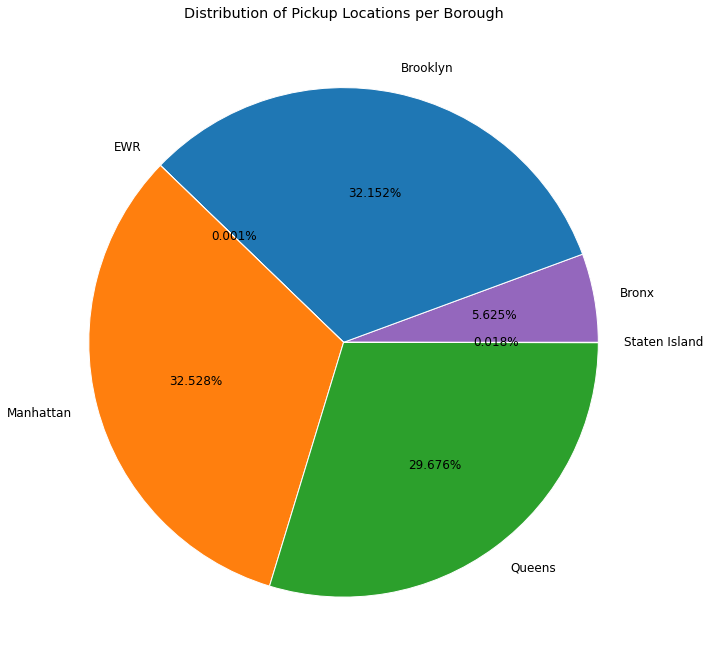

In [7]:
def categorical_cmap(nc, nsc, cmap="tab10", continuous=False):
    if nc > plt.get_cmap(cmap).N:
        raise ValueError("Too many categories for colormap.")
    if continuous:
        ccolors = plt.get_cmap(cmap)(np.linspace(0,1,nc))
    else:
        ccolors = plt.get_cmap(cmap)(np.arange(nc, dtype=int))
    cols = np.zeros((nc*nsc, 3))
    for i, c in enumerate(ccolors):
        chsv = matplotlib.colors.rgb_to_hsv(c[:3])
        arhsv = np.tile(chsv,nsc).reshape(nsc,3)
        arhsv[:,1] = np.linspace(chsv[1],0.25,nsc)
        arhsv[:,2] = np.linspace(chsv[2],1,nsc)
        rgb = matplotlib.colors.hsv_to_rgb(arhsv)
        cols[i*nsc:(i+1)*nsc,:] = rgb       
    cmap = matplotlib.colors.ListedColormap(cols)
    return cmap

fig, ax = plt.subplots(figsize=(10, 10))
cmap = categorical_cmap(5, 10)
colors = cmap(np.array([40, 0, 30, 10, 20]))
ax.pie(pu_location_borough_count, labels=pu_location_borough_count.keys(), 
        colors=colors, autopct='%1.3f%%',
        wedgeprops=dict(width=1, edgecolor='w')) 

ax.set(aspect="equal", title="Distribution of Pickup Locations per Borough")
plt.tight_layout()
#plt.savefig('top_boroughs.jpg')
plt.show()

From the above plot, it is clear that Newark Airport (EWR), Bronx, and Staten Island contribute the least to the number of trips Speedr makes. On the other hand, we see that Manhattan, Brooklyn, and Queens contribute almost the same number of trips (with respect to the pickup location). However, we would like to see which zones in particular contribute the most to the number of trips and to which borough they belong to, and thus allowing us to zero in on which zones in particular are in high-demand of such services offered by Speedr. To do this, we will compare the top 10 zones in terms of demand for Speedr trips (number of Speedr trips made).

In [8]:
top_pu_zones = df.groupby(['pu_location_borough', 'pu_location_zone'])['user_id'].count().sort_values(ascending=False)[:10]
top_pu_zones

pu_location_borough  pu_location_zone    
Manhattan            East Harlem North       4698
                     East Harlem South       4088
                     Central Harlem          4072
Queens               Astoria                 3271
                     Elmhurst                3113
Manhattan            Morningside Heights     2896
                     Central Harlem North    2514
Queens               Jackson Heights         1994
Brooklyn             Fort Greene             1989
                     Park Slope              1955
Name: user_id, dtype: int64

We would also like to see their corresponding percentage contribution to the total number of logged Speedr trips.

In [9]:
top_pu_zones_percent =  (top_pu_zones / len(df) * 100).sort_values(ascending=False).apply(lambda x: f'{round(x, 1)}%')
top_pu_zones_percent

pu_location_borough  pu_location_zone    
Manhattan            East Harlem North       6.5%
                     East Harlem South       5.6%
                     Central Harlem          5.6%
Queens               Astoria                 4.5%
                     Elmhurst                4.3%
Manhattan            Morningside Heights     4.0%
                     Central Harlem North    3.5%
Queens               Jackson Heights         2.7%
Brooklyn             Fort Greene             2.7%
                     Park Slope              2.7%
Name: user_id, dtype: object

And now we would like to generate a nested pie chart for better visualization.

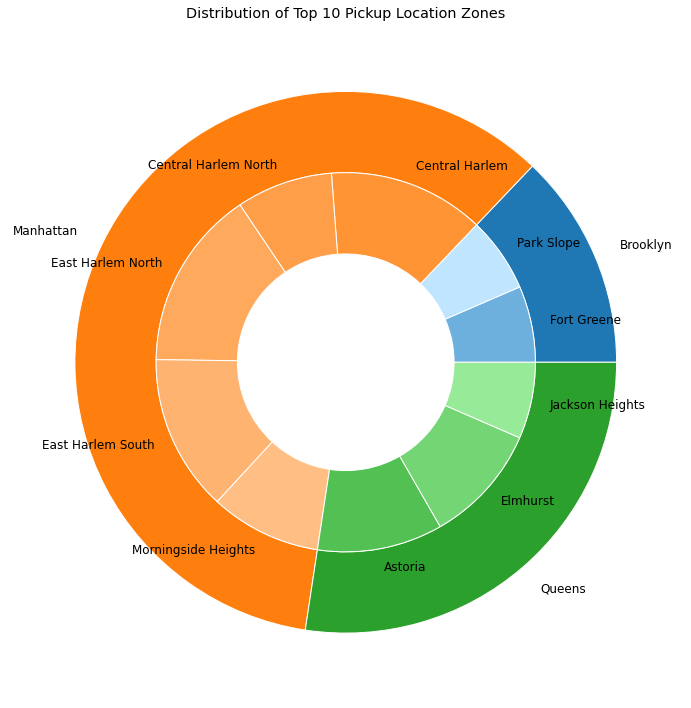

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))

size = 0.3
top_pu_zones = top_pu_zones.groupby(['pu_location_borough', 'pu_location_zone']).sum()

cmap = categorical_cmap(3, 10)
outer_colors = cmap(np.array([0, 10, 20]))
inner_colors = cmap(np.concatenate(([5, 9], np.arange(12, 17), [23, 25, 27])))

ax.pie(top_pu_zones.sum(level=0), radius=1, colors=outer_colors,
       labels=top_pu_zones.sum(level=0).keys(),# autopct='%1.3f%%',
       wedgeprops=dict(width=size, edgecolor='w'))
ax.pie(top_pu_zones.values, radius=1-size, colors=inner_colors,
       labels=top_pu_zones.droplevel(0).keys(),# autopct='%1.3f%%',
       wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect="equal", title="Distribution of Top 10 Pickup Location Zones")
plt.tight_layout()
#plt.savefig('top_zones.jpg')
plt.show()

From this alone, we can pinpoint where exactly Speedr should focus their operations on. Specifically, we see that Harlem contributes the most to the demand for commuter services. More specifically, it is advisable that Speedr focuses on East Harlem and Central Harlem. In a broader perspective, this tells us that Upper Manhattan has a high demand for commuter services.

## 2. App-dispatched trips are less common but generate more revenue (per trip on average) than street-hailed trips

This insight answers the questions "*Which trip type is more common? Which trip type generates more revenue?*"

This will give us an idea on which trip type Speedr should focus on. Furthermore, this will also give us an idea on how popular Speedr's app is.

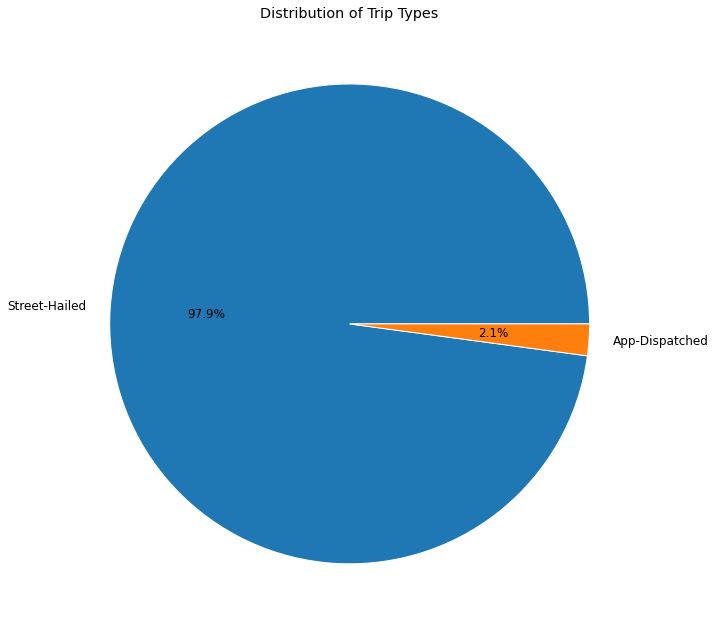

In [11]:
trip_type_groups = df.groupby('trip_type')['user_id'].count()
fig, ax = plt.subplots(figsize=(10, 10))
cmap = categorical_cmap(2, 10)
colors = cmap(np.array([0, 10]))
ax.pie(trip_type_groups, labels=trip_type_groups.keys().map({1:'Street-Hailed', 2:'App-Dispatched'}), 
        colors=colors, autopct='%1.1f%%',
        wedgeprops=dict(width=1, edgecolor='w')) 

ax.set(aspect="equal", title="Distribution of Trip Types")
plt.tight_layout()
#plt.savefig('trip_types.jpg')
plt.show()

From the pie chart above, we notice a signifant difference on the distribution of trip types in terms of total logged trips. As street-hailed trips are more common, this could mean one of two things:
1. Street hailing is more convenient for commuters. This could be because a cab can easily pull over as compared to waiting for one via an app.
2. Speedr's app is not too popular among commuters. It is possible that not too many trips are app-dispatched for the sole reason that the app is not as popular as Speedr hoped for (possibly due to lack of advertising), or it could be that street-hailing is more convenient (as mentioned above).

At this point, we would like to compare the average fare amount of both trip types with respect to the day of the week and time of the day.

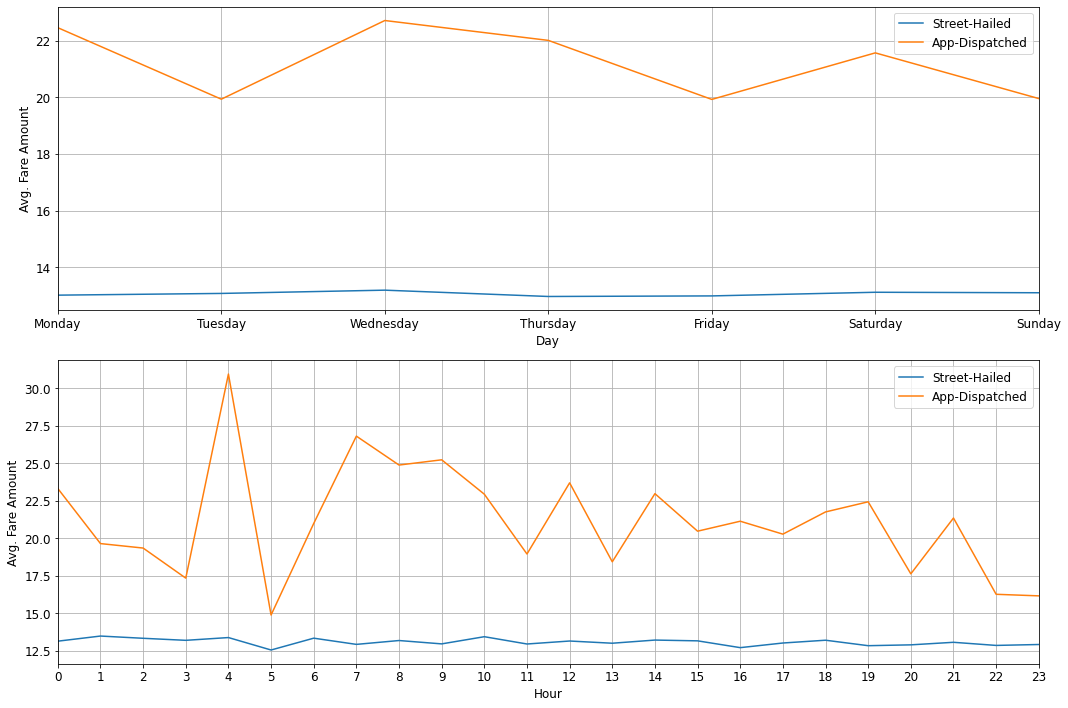

In [12]:
trip_type_day_avg_fare = df.groupby(['trip_type', 'day_of_week'])['fare_amount'].mean()
trip_type_hour_avg_fare = df.groupby(['trip_type', 'hour'])['fare_amount'].mean()

fig, ax = plt.subplots(2, 1, figsize=(15, 10))
ax[0].plot(trip_type_day_avg_fare[1].index, trip_type_day_avg_fare[1], label='Street-Hailed')
ax[0].plot(trip_type_day_avg_fare[2].index, trip_type_day_avg_fare[2], label='App-Dispatched')
ax[0].set_xticks(np.arange(7))
ax[0].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax[0].set_xlim([trip_type_day_avg_fare[1].index[0], trip_type_day_avg_fare[1].index[-1]])
ax[0].set_xlabel('Day'); ax[0].set_ylabel('Avg. Fare Amount')
ax[0].grid(True)
ax[0].legend(loc='best')

ax[1].plot(trip_type_hour_avg_fare[1].index, trip_type_hour_avg_fare[1], label='Street-Hailed')
ax[1].plot(trip_type_hour_avg_fare[2].index, trip_type_hour_avg_fare[2], label='App-Dispatched')
ax[1].set_xticks(np.arange(24))
ax[1].set_xlim([trip_type_hour_avg_fare[1].index[0], trip_type_hour_avg_fare[1].index[-1]])
ax[1].set_xlabel('Hour'); ax[1].set_ylabel('Avg. Fare Amount')
ax[1].grid(True)
ax[1].legend(loc='best')

plt.tight_layout()
#plt.savefig('avg_fare.jpg')
plt.show()

Despite app-dispatched trips being less common, it is clear from the above plots that at any given day and at any given hour, the average fare amount of app-dispatched trips are more than that of street-hailed trips. This suggests that Speedr should invest more on advertising for their app as it has clearly been shown to generate more revenue in terms average fare amount. However, this number could change as more users opt for app-dispatched trips.

## 3. Nightlife comes alive during weekends

This insight answers the question "*At what time do the number of commuters peak?*"

This will give us an idea on the time of the day per day of the week Speedr should send out more drivers to accommodate the increasing number of commuters. First of all, we would like to see the distribution of logged trips throughout the week.

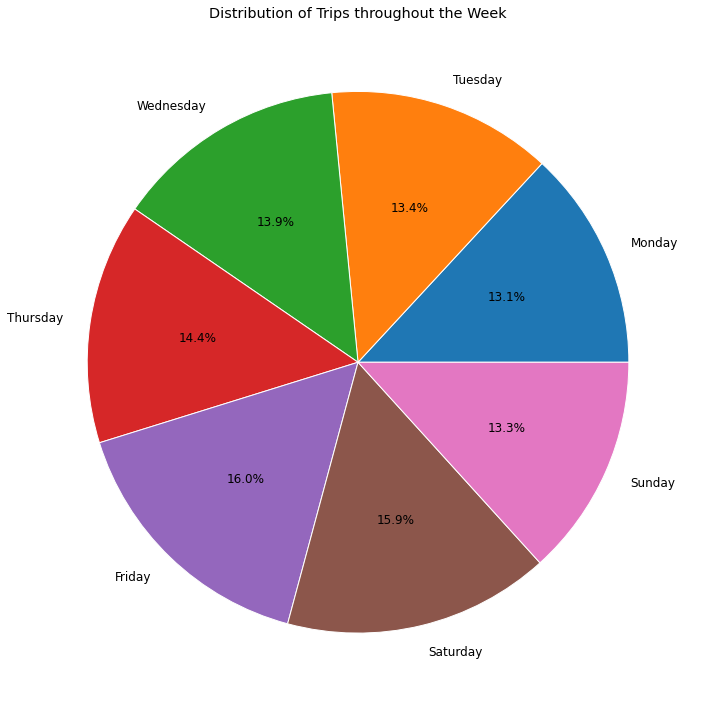

In [13]:
pass_count_day = df.groupby('day_of_week')['user_id'].count()
days = {0:'Monday',
        1:'Tuesday',
        2:'Wednesday',
        3:'Thursday',
        4:'Friday',
        5:'Saturday',
        6:'Sunday'}
hours = np.arange(24)

fig, ax = plt.subplots(figsize=(10, 10))
cmap = categorical_cmap(2, 10)
colors = cmap(np.array([0, 10]))
ax.pie(pass_count_day, labels=pass_count_day.index.map(days), 
        autopct='%1.1f%%',
        wedgeprops=dict(width=1, edgecolor='w')) 

ax.set(aspect="equal", title="Distribution of Trips throughout the Week")
plt.tight_layout()
#plt.savefig('trips_day.jpg')
plt.show()

We see that the number of trips is almost evenly distributed throughout the week, which doesn't tell us much. We would then like to narrow down the precision to the hour of the day and see how the number of commuters varies throughout the time of the day per day of the week.

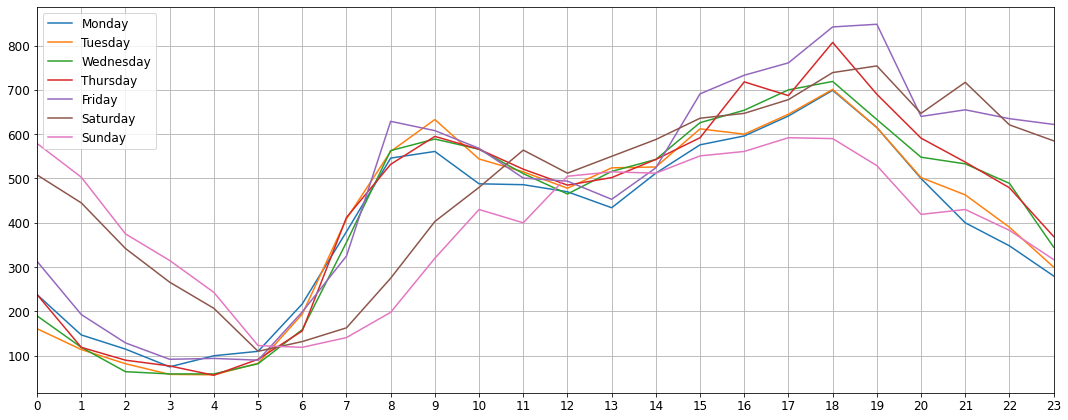

In [14]:
pass_count_hour = df.groupby(['day_of_week', 'hour'])['user_id'].count()
fig, ax = plt.subplots(figsize=(15, 6))

for day in range(7):
    ax.plot(pass_count_hour[day].index, pass_count_hour[day], label=f'{days[day]}')
    ax.set_xticks(hours)
    ax.set_xlim([hours[0], hours[-1]])

ax.legend(loc='upper left')
ax.grid(True)
plt.tight_layout()
#plt.savefig('trips_hour.jpg')
plt.show()

It is clear from this plot that the commuter count (number of commuters) during weekdays first peak as early as 8:00 AM and peak again later at 5:00 PM, whereas downtime during weekdays are at around midnight and midday. However, during weekends, we see a peak in the number of commuters at around midnight and another peak at around midday. You could say that as the average person is beginning their day during weekdays, the average person is having some downtime during weekends. This tells us that Speedr should send out more drivers close to midnight and only send out more again at around midday during weekends, whereas more drivers should be sent out at daylight hours during weekdays.

## Recommendations

1. Speedr should focus their operations more on Harlem as it is known for high demands for commuter services. Specifically, Speedr should focus on East Harlem and Central Harlem. Furthermore, Speedr should withdraw their services from Neward Airport (EWR), Bronx, and Staten Island as not many commuters request pickups from the said Boroughs.
2. Speedr should invest more on advertising their app. The majority of commuters prefer street hailing as compared to using the app, and there could be various reasons for this (e.g. convenience and waiting time). Therefore, further analysis on this matter is also recommended.
3. During weekdays, Speedr should send out more drivers during daylight hours and less during the hours close to midnight. On the other hand, Speedr should send out just as much drivers during midnight as compared to midday as it has been shown that more people engage in night activities during weekends as compared to weekdays.